Try to compute DCR for a given SED.

Use a SED from the sims package. Let's do this full-out from SED library as in ACB's S14DCR code.

First need to do:

```
setup -t b1740 sims_sed_library
setup -t b1740 throughputs
setup -t b1740 sims_photUtils
```

In [1]:
import os
import numpy as np

#import dcr
#import spec    ## dont forget to add $HOME/GIT_REPOS/chroma/chroma to PYTHONPATH before starting ipython notebook
#import plot
#import utils

#import _mypath
#import chroma

#bpDir = '/Users/dreiss/GIT_REPOS/chroma/data/filters/'
#bpDir = '/Users/dreiss/lsstsw/stack/DarwinX86/throughputs/master-ga98b3deed1/baseline/'
bpDir = os.environ['LSST_THROUGHPUTS_DEFAULT']
catDir = os.environ['SIMS_SED_LIBRARY_DIR']

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.style.use('ggplot')

## see http://matplotlib.org/users/colormaps.html for colormaps
from matplotlib import cm

In [2]:
import pandas as pd

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

In [3]:
import lsst.sims.photUtils.Sed as Sed
import lsst.sims.photUtils.Bandpass as Bandpass
import lsst.sims.photUtils.BandpassDict as bpDict

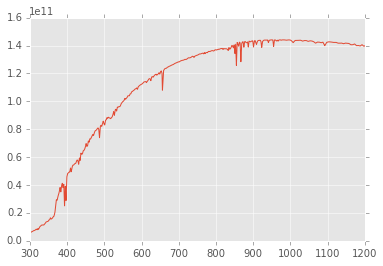

In [13]:
contLevel  = 0.01
dcrLevel   = 5e-3
sedName    = "km15_5250.fits_g05_5470.gz"
airmass1   = 1.25                                                                                                                                       
dairmasses = np.arange(-0.25, 0.26, 0.05)                                                                                                               
dthetas    = np.arange(0, 181, 5)
zd1        = np.arccos(1./airmass1) * 180/np.pi

# Extracted from Winter2014 DCR3.py
def getOffset(wavelen, flux, zd):
    off = refract(wavelen*10**-3,  zd * np.pi / 180.) * 180. / np.pi * 3600. # arcsec
    return np.sum(off * flux) / np.sum(flux)

def refract(wavelength, zd, P=520.0, T=20.0, f=8.0):
    xnm1  = 10**-6 * ( 64.328 + 29498.1 / (146.0 - 1/wavelength**2) + 255.4 / (41.0 - 1/wavelength**2) )
    xnm1 *= P * (1 + (1.049 - 0.0157 * T) * 10**-6 * P) / (720.883 * (1 + 0.003661 * T))
    xnm1 -= 10**-6 * f * (0.0624 - 0.000680/wavelength**2) / (1 + 0.003661 * T)
    xn    = xnm1 + 1
    r0    = (xn**2 - 1) / (2 * xn**2)
    of    = r0 * np.tan(zd) # radians
    return of

star_SEDname = "km15_5250.fits_g05_5470.gz"
star = Sed()
star.readSED_flambda(os.path.join(catDir, "starSED/%s/%s%s" % ('kurucz', star_SEDname, '')))
star.flambdaTofnu()

wavelen = star.wavelen
fnu = star.fnu
plt.plot(wavelen, fnu)

In [38]:
bps = bpDict.loadTotalBandpassesFromFiles()
#print bps.keys()
#print bps.fluxDictForSed(star)
#print bps['g'].wavelen
waveleng, fnug = star.resampleSED(wavelen, fnu, wavelen_match=bps['g'].wavelen)
fluxg = fnug * bps['g'].phi
dg1 = getOffset(waveleng, fluxg, zd1)
print dg1

zd2 = np.arccos(1./(airmass1 + dairmasses)) * 180./np.pi
dg2 = np.array([getOffset(waveleng, fluxg, zd) for zd in zd2])
print zd2, dg2

## wtf is this doing?
#Mg[ia, it] = print np.sqrt(dg1**2 + dg2**2 - 2 * dg1 * dg2 * np.cos(dthetas * np.pi / 180))

29.0051452645
[  0.          17.75279016  24.61997733  29.59184579  33.55730976
  36.86989765  39.71513723  42.2054464   44.4153086   46.39718103
  48.1896851 ] [  0.          12.38156991  17.7224365   21.96234154  25.65311569
  29.00514526  32.12464424  35.07371226  37.8921631   40.60720337
  43.23831767]


Looks like chroma.spec has a few useful functions like 

```
calculateDCRMomentShifts(self, bandpass, **kwargs):
```

        @returns a tuple.  The first element is the vector of DCR first moment shifts, and the
                 second element is the 2x2 matrix of DCR second (central) moment shifts.


Use same stellar spectrum as S14 study, to start...

In [11]:
from scipy.interpolate import interp1d

#gal_SED = spec.SED(datadir+'/SEDs/'+'KIN_Sa_ext.ascii')
star_SEDname = "km15_5250.fits_g05_5470.gz"
w,f = np.genfromtxt(catDir+'/starSED/kurucz/'+star_SEDname).T
#toAppend = np.arange(w.max()+0.5,1200.,0.5)
#w = np.append(w, toAppend)
#f = np.append(f, np.zeros_like(toAppend))
ss = interp1d(w, f)

SED = spec.SED(ss) ##.atRedshift(0.5)
wave = np.arange(500.0, 901.0, 1.0)
photons = SED(wave)

scale = 1.2 * photons[(wave > 500) & (wave < 1000)].max()
plt.plot(wave, photons) #/scale)

NameError: name 'spec' is not defined

Make a relative DCR curve for star (assume ZD angle 20 deg.)

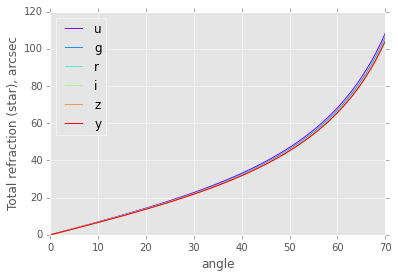

In [25]:
# filters are stored in two columns: wavelength (nm), and throughput

def compute_dcr(SED, filters='ugrizy', angles=np.linspace(0,70,14), relative=None, **kwargs):
    if type(angles) is int or type(angles) is float:
        angles = np.array([angles])
    elif type(angles) is list:
        angles = np.array(angles)        
    if type(filters) is int or type(filters) is float:
        filters = np.array([filters])
    df = pd.DataFrame(pd.Series(angles)) #, index=pd.Series(angles))
    for i, filter_ in enumerate(filters):
        if type(filter_) is str:
            fdata = spec.Bandpass(bpDir+'/filter_{}.dat'.format(filter_))
            fwave, throughput = fdata.wave_list, fdata(fdata.wave_list)
            shifts = np.array( [SED.calculateDCRMomentShifts(fdata, zenith_angle=angle * np.pi/180.0, **kwargs)[0].item(1) 
                            for angle in angles])
            shifts = shifts * 3600.0 * 180.0/np.pi            
            df = pd.concat([df, pd.Series(shifts)], axis=1, ignore_index=True)
        else: # assume it's a single wavelength value (nm) then
            shifts = np.array( [dcr.get_refraction(filter_, zenith=angle * np.pi/180.0, **kwargs) for angle in angles])
            shifts = shifts * 3600.0 * 180.0/np.pi            
            df = pd.concat([df, pd.Series(shifts)], axis=1, ignore_index=True)
             
    df.columns = np.insert(np.array(list(filters), dtype='S6'), 0, 'angle')
    df = df.set_index('angle')
    if relative is not None and np.any(df.columns.values == relative):
        df2 = df.copy().sub(df[relative], axis=0)
        return df2
    else:
        return df

angles = np.linspace(0,70,71)

DCRs = compute_dcr(SED, 'ugrizy', angles)
ax = DCRs.plot(colormap=cm.rainbow)
ax.set_ylabel('Total refraction (star), arcsec')

#DCRs = compute_dcr(sn_SED, 'ugrizy', angles, relative='r')
#ax = DCRs.plot(colormap=cm.rainbow)
#ax.set_ylabel('Relative refraction, arcsec')

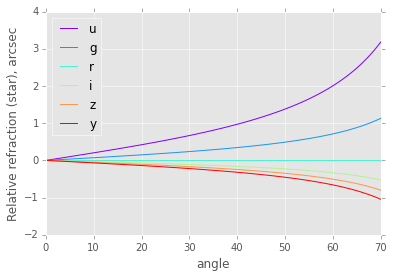

In [26]:
DCRs = compute_dcr(SED, 'ugrizy', angles, relative='r')
ax = DCRs.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative refraction (star), arcsec')

#DCRs_gal = compute_dcr(gal_SED, 'ugrizy', angles, relative='r')
#ax = DCRs_gal.plot(colormap=cm.rainbow)
#ax.set_ylabel('Relative refraction, arcsec')

In [23]:
print 69.328/0.13332239
print 749.3/10./0.13332239
print
print dcr.air_refractive_index(600.)
print dcr.air_refractive_index2(600.)
print
print dcr.get_refraction(600., 20. * np.pi/180.0, pressure=69.328, temperature=293.15, H2O_pressure=1.067)  * 3600.0 * 180.0/np.pi
print dcr.get_refraction(600., 20. * np.pi/180.0, pressure=69.328, temperature=293.15-3., H2O_pressure=1.067)  * 3600.0 * 180.0/np.pi
print dcr.get_refraction(600., 20. * np.pi/180.0, pressure=69.328, temperature=293.15+19., H2O_pressure=1.067)  * 3600.0 * 180.0/np.pi
print
print compute_dcr(SED, filters=600., angles=20., temperature=293.15).ix[20][0]
print compute_dcr(SED, filters=600., angles=20., temperature=293.15-3.).ix[20][0]
print compute_dcr(SED, filters=600., angles=20., temperature=293.15+19.).ix[20][0]
print
print compute_dcr(SED, filters='r', angles=20., temperature=293.15).ix[20][0]
print compute_dcr(SED, filters='r', angles=20., temperature=293.15-3.).ix[20][0]
print compute_dcr(SED, filters='r', angles=20., temperature=293.15+19.).ix[20][0]
print
print compute_dcr(SED, filters='r', angles=20., temperature=293.15).ix[20][0]


520.00267922
562.021127884

1.00018577948
1.00018582692

13.9433693327
14.0878418669
13.0928475368

13.9433693327
14.0878418669
13.0928475368

13.9322461535
14.0766034703
13.0824026646

13.9322461535
